In [1]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

In [63]:
# Loading data from JobLevelData.xlsx
df = pd.read_excel('JobLevelData.xlsx', na_values=['NA', 'missing', ''], 
                  keep_default_na=True)

In [64]:
# Quick view over dataset structure
print(df.head())

                                               Title        Column 1  \
0   Vice President / Director of Systems Engineering  Vice President   
1                Systems Engineer; Systems Architect         Manager   
2  Executive Director, Global IT Infrastructure /...        Director   
3      CTO/Executive Director of Technology Services        Director   
4                                Vice President, CIO  Vice President   

                       Column 2 Column 3 Column 4  
0                           NaN      NaN      NaN  
1  Individual Contributor/Staff      NaN      NaN  
2                 Chief Officer      NaN      NaN  
3                 Chief Officer      NaN      NaN  
4                           NaN      NaN      NaN  


In [5]:
# Count emty cells in each column
df.isna().sum()

Title          0
Column 1      10
Column 2    2107
Column 3    2228
Column 4    2229
dtype: int64

In [6]:
# General information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     2240 non-null   object
 1   Column 1  2230 non-null   object
 2   Column 2  133 non-null    object
 3   Column 3  12 non-null     object
 4   Column 4  11 non-null     object
dtypes: object(5)
memory usage: 87.6+ KB


In [8]:
# Here it's being shown that in the first column all entries are unique
unique_titles = df['Title'].unique
print(unique_titles)

<bound method Series.unique of 0        Vice President / Director of Systems Engineering
1                     Systems Engineer; Systems Architect
2       Executive Director, Global IT Infrastructure /...
3           CTO/Executive Director of Technology Services
4                                     Vice President, CIO
                              ...                        
2235         Net Software Architect and Team Project Lead
2236                 Solutions Architect & Technical Lead
2237    Manager, Salesforcecom Administration and Rele...
2238                      Innovation Automation Architect
2239        Founder and Chief Executive Officer, Kindbody
Name: Title, Length: 2240, dtype: object>


In [9]:
# Congirmation that all titles are unique
num_unique = df['Title'].nunique()
print(num_unique)

2240


In [84]:
'''Now it's necessary to look over other columns and as we see 
from below insight, here is multi-label classification problem and 
it seems that the dataset is severely imbalanced:
compare 1105 "Individual Contributor/Staff" labels to 
only 4 "Owner"
Further on I will use some balancing techniques like oversampling, 
class weights and iterative stratified sampling. Last technique was
specifically designed for imbalanced datasets and gives the ability
 to split dataset having each label in each split
'''
# Combine all non-empty values from all columns and count them
combined_counts = pd.Series()

for col in ['Column 1', 'Column 2', 'Column 3', 'Column 4']:
    # Get value counts for non-empty values in each column
    counts = df[col].dropna().value_counts()
    # Add to combined counts (summing duplicates)
    combined_counts = combined_counts.add(counts, fill_value=0)
# Sort values in descending order
combined_counts = combined_counts.sort_values(ascending=False)
print(combined_counts)

Individual Contributor/Staff    1105.0
Director                         497.0
Vice President                   403.0
Manager                          211.0
Chief Officer                    166.0
Owner                              4.0
dtype: object


In [16]:
# Checking which labels presented in each column
# Loop through columns 1-4 and show unique values with counts
for col in ['Column 1', 'Column 2', 'Column 3', 'Column 4']:
    print(f"\nUnique values in {col}:")
    print(df[col].value_counts())
    print(f"Total unique values in {col}: {df[col].nunique()}")
    print("-" * 50)  # Separator for readability


Unique values in Column 1:
Column 1
Individual Contributor/Staff    1039
Director                         470
Vice President                   403
Manager                          190
Chief Officer                    124
Owner                              4
Name: count, dtype: int64
Total unique values in Column 1: 6
--------------------------------------------------

Unique values in Column 2:
Column 2
Individual Contributor/Staff    55
Chief Officer                   42
Manager                         21
Director                        15
Name: count, dtype: int64
Total unique values in Column 2: 4
--------------------------------------------------

Unique values in Column 3:
Column 3
Individual Contributor/Staff    11
Director                         1
Name: count, dtype: int64
Total unique values in Column 3: 2
--------------------------------------------------

Unique values in Column 4:
Column 4
Director    11
Name: count, dtype: int64
Total unique values in Column 4: 1
--------

In [ ]:
'''It is clearly visible from the last operation that there's some 
labels descent with each column: Number of total unique values jumps 
from 6 to 1 
with step 2 like so 6-4-2-1.
This could be a sign of hieratchical data representation, which I will check 
later on in this file
'''

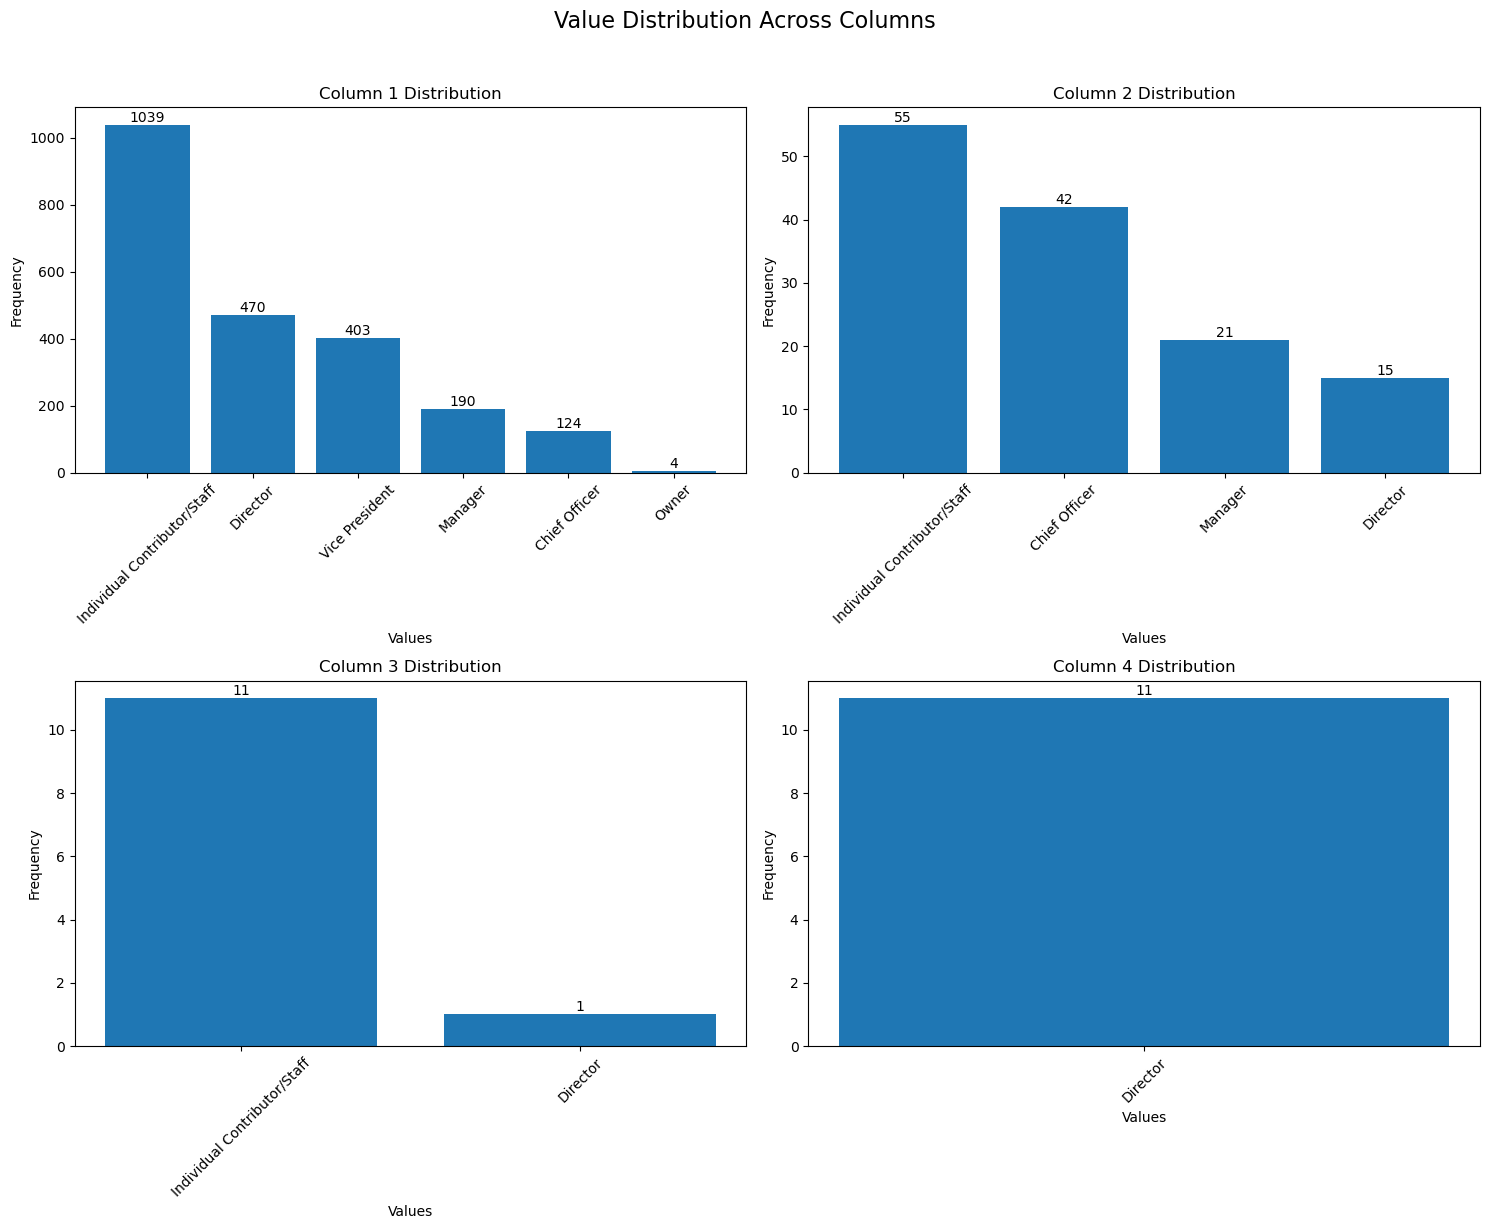

In [17]:
# Create subplots for all 4 columns to have visual representation
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Value Distribution Across Columns', fontsize=16, y=1.02)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Create bar plots for each column
for idx, col in enumerate(['Column 1', 'Column 2', 'Column 3', 'Column 4']):
    # Get value counts
    counts = df[col].value_counts()
    
    # Create bar plot
    bars = axes[idx].bar(counts.index, counts.values)
    
    # Customize each subplot
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].set_xlabel('Values')
    axes[idx].set_ylabel('Frequency')
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{int(height)}',
                      ha='center', va='bottom')

plt.tight_layout()
plt.show()

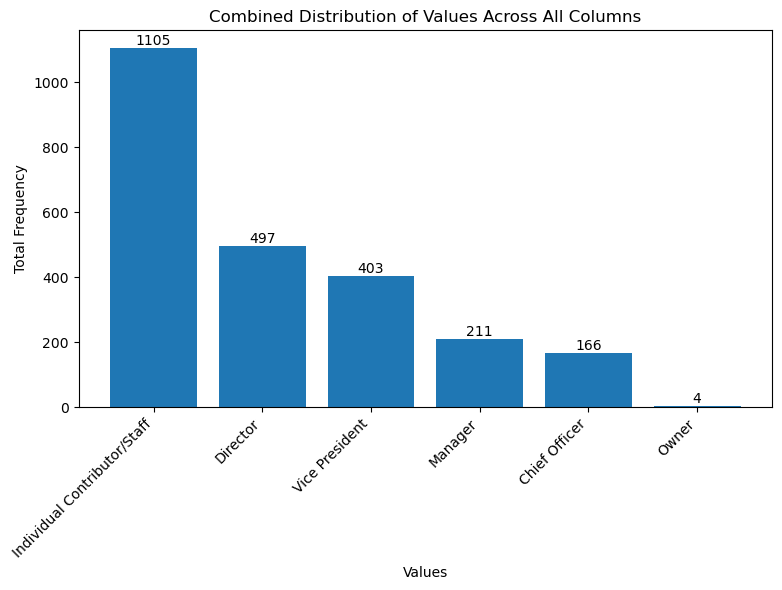


Combined value counts across all columns:
Individual Contributor/Staff    1105.0
Director                         497.0
Vice President                   403.0
Manager                          211.0
Chief Officer                    166.0
Owner                              4.0
dtype: object


In [23]:
# Combine all non-empty values from all columns and count them
combined_counts = pd.Series()

for col in ['Column 1', 'Column 2', 'Column 3', 'Column 4']:
    # Get value counts for non-empty values in each column
    counts = df[col].dropna().value_counts()
    # Add to combined counts (summing duplicates)
    combined_counts = combined_counts.add(counts, fill_value=0)

# Sort values in descending order
combined_counts = combined_counts.sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(8, 6))
bars = plt.bar(combined_counts.index, combined_counts.values)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.title('Combined Distribution of Values Across All Columns')
plt.xlabel('Values')
plt.ylabel('Total Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print the combined counts
print("\nCombined value counts across all columns:")
print(combined_counts)

In [4]:
# For each row, check if labels in Column 2 appear in Column 1
def check_hierarchy(df):
    for idx, row in df.iterrows():
        for col_num in [2, 3, 4]:  # Check columns 1,2,3,4
            current_value = row[f'Column {col_num}']
            if pd.notna(current_value):  # If there's a value
                previous_value = row[f'Column {col_num-1}']
                if current_value not in df[f'Column {col_num-1}'].unique():
                    print(f"Hierarchy violation at row {idx}: {current_value} in Column {col_num} not found in Column {col_num-1}")

check_hierarchy(df)

In [5]:
print(check_hierarchy(df))

None


In [12]:
for idx, row in df.iterrows():
    print(row)

Title       Vice President / Director of Systems Engineering
Column 1                                      Vice President
Column 2                                                 NaN
Column 3                                                 NaN
Column 4                                                 NaN
Name: 0, dtype: object
Title       Systems Engineer; Systems Architect
Column 1                                Manager
Column 2           Individual Contributor/Staff
Column 3                                    NaN
Column 4                                    NaN
Name: 1, dtype: object
Title       Executive Director, Global IT Infrastructure /...
Column 1                                             Director
Column 2                                        Chief Officer
Column 3                                                  NaN
Column 4                                                  NaN
Name: 2, dtype: object
Title       CTO/Executive Director of Technology Services
Column 1          

Title       Senior System Administration Technologist
Column 1                 Individual Contributor/Staff
Column 2                                          NaN
Column 3                                          NaN
Column 4                                          NaN
Name: 278, dtype: object
Title                   Advanced Analyst
Column 1    Individual Contributor/Staff
Column 2                             NaN
Column 3                             NaN
Column 4                             NaN
Name: 279, dtype: object
Title          Senior Events Coordinator
Column 1    Individual Contributor/Staff
Column 2                             NaN
Column 3                             NaN
Column 4                             NaN
Name: 280, dtype: object
Title       CRM Data Quality & Campaign Specialist
Column 1              Individual Contributor/Staff
Column 2                                       NaN
Column 3                                       NaN
Column 4                                 

Title       Certified Trainer & Sales Supervisor
Column 1            Individual Contributor/Staff
Column 2                                     NaN
Column 3                                     NaN
Column 4                                     NaN
Name: 492, dtype: object
Title              Accounting Supervisor
Column 1    Individual Contributor/Staff
Column 2                             NaN
Column 3                             NaN
Column 4                             NaN
Name: 493, dtype: object
Title       Senior Partner Account Executive
Column 1        Individual Contributor/Staff
Column 2                                 NaN
Column 3                                 NaN
Column 4                                 NaN
Name: 494, dtype: object
Title       Senior Media Relations Associate
Column 1        Individual Contributor/Staff
Column 2                                 NaN
Column 3                                 NaN
Column 4                                 NaN
Name: 495, dtype: object


Title       Vice President / Recruiting Manager
Column 1                         Vice President
Column 2                                    NaN
Column 3                                    NaN
Column 4                                    NaN
Name: 785, dtype: object
Title              Global Communications
Column 1    Individual Contributor/Staff
Column 2                             NaN
Column 3                             NaN
Column 4                             NaN
Name: 786, dtype: object
Title       Senior Supervisor, Electric Field Operations
Column 1                    Individual Contributor/Staff
Column 2                                             NaN
Column 3                                             NaN
Column 4                                             NaN
Name: 787, dtype: object
Title                Corporate Associate
Column 1    Individual Contributor/Staff
Column 2                             NaN
Column 3                             NaN
Column 4                       

Title       Head of the External Control Unit, Regional Co...
Column 1                                             Director
Column 2                                                  NaN
Column 3                                                  NaN
Column 4                                                  NaN
Name: 1110, dtype: object
Title       Head of the Consumer, Mortgage and Pledge Cred...
Column 1                                             Director
Column 2                                                  NaN
Column 3                                                  NaN
Column 4                                                  NaN
Name: 1111, dtype: object
Title             Data Analyst Analytics
Column 1    Individual Contributor/Staff
Column 2                             NaN
Column 3                             NaN
Column 4                             NaN
Name: 1112, dtype: object
Title       Audit & Compliance Director
Column 1                       Director
Column 2         

Title       SN Associate Operator Programs and Engagement
Column 1                                          Manager
Column 2                     Individual Contributor/Staff
Column 3                                              NaN
Column 4                                              NaN
Name: 1370, dtype: object
Title       Metalworking Technical Support Representative
Column 1                     Individual Contributor/Staff
Column 2                                              NaN
Column 3                                              NaN
Column 4                                              NaN
Name: 1371, dtype: object
Title       Director, Provider Engagement
Column 1                         Director
Column 2                              NaN
Column 3                              NaN
Column 4                              NaN
Name: 1372, dtype: object
Title       Staff Support Engineer Technical
Column 1        Individual Contributor/Staff
Column 2                                 N

Title       Global Sales & Growth Leader, Business Aviatio...
Column 1                                              Manager
Column 2                         Individual Contributor/Staff
Column 3                                                  NaN
Column 4                                                  NaN
Name: 1555, dtype: object
Title       Associate Business Development Manger
Column 1                                  Manager
Column 2             Individual Contributor/Staff
Column 3                                      NaN
Column 4                                      NaN
Name: 1556, dtype: object
Title       Associate Digital Marketing Manager
Column 1           Individual Contributor/Staff
Column 2                                    NaN
Column 3                                    NaN
Column 4                                    NaN
Name: 1557, dtype: object
Title       Team Lead, Annuity Sales and New Business
Column 1                 Individual Contributor/Staff
Column 2      

Title       Executive Vice President for Corporate Strategy
Column 1                                     Vice President
Column 2                                                NaN
Column 3                                                NaN
Column 4                                                NaN
Name: 1760, dtype: object
Title       Global Business Transformation Lead
Column 1           Individual Contributor/Staff
Column 2                                    NaN
Column 3                                    NaN
Column 4                                    NaN
Name: 1761, dtype: object
Title       VP HR Consumer Market
Column 1           Vice President
Column 2                      NaN
Column 3                      NaN
Column 4                      NaN
Name: 1762, dtype: object
Title       VP Group Communications & IR
Column 1                  Vice President
Column 2                             NaN
Column 3                             NaN
Column 4                             NaN
Name: 1

Title       Academy Manager
Column 1            Manager
Column 2                NaN
Column 3                NaN
Column 4                NaN
Name: 1997, dtype: object
Title       COO / Vice VD
Column 1    Chief Officer
Column 2              NaN
Column 3              NaN
Column 4              NaN
Name: 1998, dtype: object
Title       Service Manager/ Team leader
Column 1                         Manager
Column 2                             NaN
Column 3                             NaN
Column 4                             NaN
Name: 1999, dtype: object
Title       Lead Solution Architect and Partner
Column 1                                Manager
Column 2                                    NaN
Column 3                                    NaN
Column 4                                    NaN
Name: 2000, dtype: object
Title       Manager, Dynamic Policy, Prudential Policy Dep...
Column 1                                              Manager
Column 2                                                 

In [13]:
# Create a new dataframe to check filled cells 
filled_cells_df = df.notna() & df.ne('')
print(filled_cells_df)

      Title  Column 1  Column 2  Column 3  Column 4
0      True      True     False     False     False
1      True      True      True     False     False
2      True      True      True     False     False
3      True      True      True     False     False
4      True      True     False     False     False
...     ...       ...       ...       ...       ...
2235   True      True     False     False     False
2236   True      True      True     False     False
2237   True      True     False     False     False
2238   True      True     False     False     False
2239   True      True     False     False     False

[2240 rows x 5 columns]


In [14]:
# Create a column to count the number of filled cells in each row 
df['Filled Count'] = df.notna().sum(axis=1) + df.ne('').sum(axis=1) - 1 # Subtract 1 to exclude the 'Title' column 

# Group by the count of filled columns and get the labels 
grouped = df.groupby('Filled Count').apply(lambda x: x.drop(columns='Filled Count')).reset_index() 
print(grouped)

      Filled Count  level_1  \
0                5       29   
1                5      341   
2                5      511   
3                5      764   
4                5      829   
...            ...      ...   
2235             9      755   
2236             9     1108   
2237             9     1122   
2238             9     1689   
2239             9     1924   

                                                  Title        Column 1  \
0                                                  CINO             NaN   
1                                  Ticari Subesi Muduru             NaN   
2     Governor, Chair of Board Risk and Audit Commit...             NaN   
3            Former Director, Compensation and Benefits             NaN   
4                        Release of Information Tech II             NaN   
...                                                 ...             ...   
2235  Interim Chief Officer of Strategic Place Planning  Vice President   
2236                       

C:\Users\RedmiBook\AppData\Local\Temp\ipykernel_460\2776993752.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('Filled Count').apply(lambda x: x.drop(columns='Filled Count')).reset_index()


In [19]:
# Check relationship between Column 1 and Column 2
print(pd.crosstab(df['Column 1'], df['Column 2'], margins=True))

Column 2                      Chief Officer  Director  \
Column 1                                                
Director                                 25         0   
Individual Contributor/Staff              3         0   
Manager                                  11        15   
Owner                                     3         0   
Vice President                            0         0   
All                                      42        15   

Column 2                      Individual Contributor/Staff  Manager  All  
Column 1                                                                  
Director                                                 1        0   26  
Individual Contributor/Staff                             0        0    3  
Manager                                                 54        0   80  
Owner                                                    0        0    3  
Vice President                                           0       21   21  
All               

In [17]:
# Check relationship between Column 2 and Column 3
print(pd.crosstab(df['Column 2'], df['Column 3'], margins=True))

Column 3  Director  Individual Contributor/Staff  All
Column 2                                             
Manager          1                            11   12
All              1                            11   12


In [18]:
# Check relationship between Column 3 and Column 4
print(pd.crosstab(df['Column 3'], df['Column 4'], margins=True))

Column 4                      Director  All
Column 3                                   
Individual Contributor/Staff        11   11
All                                 11   11


In [22]:
# Check relationship between Column 1,Column 2, 3 and 4
print(pd.crosstab(index=[df['Column 1']], columns=[df['Column 2'], df['Column 3'],
                                                  df['Column 4']], margins=True))

Column 2                            Manager All
Column 3       Individual Contributor/Staff    
Column 4                           Director    
Column 1                                       
Vice President                           11  11
All                                      11  11


In [28]:
# Step 1: Check if columns form a hierarchy
def isit_hierarchy(df, parent_col, child_col):
    # Group by parent and collect unique child values
    parent_child_mapping = df.groupby(parent_col)[child_col].unique().to_dict()
    return parent_child_mapping

# Apply the check between consecutive columns
hierarchy_1_to_2 = isit_hierarchy(df, 'Column 1', 'Column 2')
hierarchy_2_to_3 = isit_hierarchy(df, 'Column 2', 'Column 3')
hierarchy_3_to_4 = isit_hierarchy(df, 'Column 3', 'Column 4')

print("Hierarchy from label_1 to label_2:", hierarchy_1_to_2)
print("Hierarchy from label_2 to label_3:", hierarchy_2_to_3)
print("Hierarchy from label_3 to label_4:", hierarchy_3_to_4)

Hierarchy from label_1 to label_2: {'Chief Officer': array([nan], dtype=object), 'Director': array(['Chief Officer', nan, 'Individual Contributor/Staff'], dtype=object), 'Individual Contributor/Staff': array([nan, 'Chief Officer'], dtype=object), 'Manager': array(['Individual Contributor/Staff', 'Chief Officer', 'Director', nan],
      dtype=object), 'Owner': array(['Chief Officer', nan], dtype=object), 'Vice President': array([nan, 'Manager'], dtype=object)}
Hierarchy from label_2 to label_3: {'Chief Officer': array([nan], dtype=object), 'Director': array([nan], dtype=object), 'Individual Contributor/Staff': array([nan], dtype=object), 'Manager': array(['Individual Contributor/Staff', nan, 'Director'], dtype=object)}
Hierarchy from label_3 to label_4: {'Director': array([nan], dtype=object), 'Individual Contributor/Staff': array(['Director'], dtype=object)}


In [33]:
# Function to validate hierarchy rules
def validate_hierarchy_row(row):
    if row['Column 4'] and pd.isna(row['Column 3']):
        return False  # label_4 exists, but label_3 is missing
    if row['Column 3'] and pd.isna(row['Column 2']):
        return False  # label_3 exists, but label_2 is missing
    if row['Column 2'] and pd.isna(row['Column 1']):
        return False  # label_2 exists, but label_1 is missing
    return True

# Apply validation
df['is_valid'] = df.apply(validate_hierarchy_row, axis=1)
print(df)

                                                  Title        Column 1  \
0      Vice President / Director of Systems Engineering  Vice President   
1                   Systems Engineer; Systems Architect         Manager   
2     Executive Director, Global IT Infrastructure /...        Director   
3         CTO/Executive Director of Technology Services        Director   
4                                   Vice President, CIO  Vice President   
...                                                 ...             ...   
2235       Net Software Architect and Team Project Lead         Manager   
2236               Solutions Architect & Technical Lead         Manager   
2237  Manager, Salesforcecom Administration and Rele...         Manager   
2238                    Innovation Automation Architect         Manager   
2239      Founder and Chief Executive Officer, Kindbody   Chief Officer   

                          Column 2 Column 3 Column 4  Filled Count  is_valid  
0                   

In [34]:
# Here I combine each label appearence in each column into path to see
# how many label combinations dataset has and do them form a data hierarchy
# Combine columns into paths
df['label_path'] = df[['Column 1', 'Column 2', 'Column 3', 'Column 4']].apply(
    lambda x: ' > '.join(filter(lambda y: not pd.isna(y), x)), axis=1)

# Count occurrences of each path
path_counts = df['label_path'].value_counts()
print(path_counts)

label_path
Individual Contributor/Staff                                          1036
Director                                                               444
Vice President                                                         382
Chief Officer                                                          124
Manager                                                                110
Manager > Individual Contributor/Staff                                  54
Director > Chief Officer                                                25
Manager > Director                                                      15
Vice President > Manager > Individual Contributor/Staff > Director      11
Manager > Chief Officer                                                 11
                                                                        10
Vice President > Manager                                                 9
Individual Contributor/Staff > Chief Officer                             3
Owner > Chief 

In [36]:
# Filter rows with sparse paths
sparse_paths = df[df['Filled Count'] < 3]
print(sparse_paths[['Title', 'Column 1', 'Column 2', 'Column 3', 'Column 4']])

Empty DataFrame
Columns: [Title, Column 1, Column 2, Column 3, Column 4]
Index: []


In [40]:
# Step 1: Analyze sparsity by counting non-null values across label columns per row
df['non_null_count'] = df[['Column 1', 'Column 2', 'Column 3', 'Column 4']].notnull().sum(axis=1)

# Distribution of non-null counts across rows
non_null_distribution = df['non_null_count'].value_counts()

# Step 2: Focus on rows where Column 2, Column 3, or Column 4 is non-null to analyze relationships
sparse_data = df.dropna(subset=['Column 2', 'Column 3', 'Column 4'], how='all')

# Group rows by unique parent-child paths
grouped_paths = sparse_data.groupby(['Column 1', 'Column 2', 'Column 3', 'Column 4']).size().reset_index(name='Count')

# Display results
print(non_null_distribution)
print(sparse_data.shape) 
print(grouped_paths)

non_null_count
1    2097
2     121
4      11
0      10
3       1
Name: count, dtype: int64
(133, 9)
         Column 1 Column 2                      Column 3  Column 4  Count
0  Vice President  Manager  Individual Contributor/Staff  Director     11


In [ ]:
'''Most Rows (2097): Only Column 1 is populated.
Sparse Rows (133): Have at least one value in 
Column 2, Column 3, or Column 4.
Obviously 133 rows is just above 5% of all data, which
in my opinion is not enough to proof hierarchy, hence 
I'm going to treat this as just multi-label problem
'''

In [5]:
# Func to print whole dataset
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
#print_full(sparse_data)

In [61]:
# Save sparse rows to a new Excel file
sparse_data.to_excel('Sparse_Rows_Analysis.xlsx', index=False)

In [38]:
df.isna().sum()

Title                0
Column 1            10
Column 2          2107
Column 3          2228
Column 4          2229
Filled Count         0
is_valid             0
label_path           0
non_null_count       0
dtype: int64

In [48]:
# Count non-null values in each column for sparse rows
sparse_non_null_counts = sparse_data[['Column 2', 'Column 3', 'Column 4']].notnull().sum()
print(sparse_non_null_counts)

Column 2    133
Column 3     12
Column 4     11
dtype: int64


In [49]:
# Unique values in each column
unique_values = {
    'Column 2': sparse_data['Column 2'].dropna().unique(),
    'Column 3': sparse_data['Column 3'].dropna().unique(),
    'Column 4': sparse_data['Column 4'].dropna().unique()
}
print(unique_values)

{'Column 2': array(['Individual Contributor/Staff', 'Chief Officer', 'Manager',
       'Director'], dtype=object), 'Column 3': array(['Individual Contributor/Staff', 'Director'], dtype=object), 'Column 4': array(['Director'], dtype=object)}


In [50]:
# Group by unique combinations of label columns
grouped_relationships = sparse_data.groupby(['Column 1', 'Column 2', 'Column 3', 'Column 4']).size().reset_index(name='Count')
print(grouped_relationships)

         Column 1 Column 2                      Column 3  Column 4  Count
0  Vice President  Manager  Individual Contributor/Staff  Director     11


In [52]:
# Group by unique combinations of label columns
grouped_relationships = sparse_data.groupby(['Column 1', 'Column 2']).size().reset_index(name='Count')
print(grouped_relationships)

                       Column 1                      Column 2  Count
0                      Director                 Chief Officer     25
1                      Director  Individual Contributor/Staff      1
2  Individual Contributor/Staff                 Chief Officer      3
3                       Manager                 Chief Officer     11
4                       Manager                      Director     15
5                       Manager  Individual Contributor/Staff     54
6                         Owner                 Chief Officer      3
7                Vice President                       Manager     21


In [53]:
# Group by unique combinations of label columns
grouped_relationships = sparse_data.groupby(['Column 2', 'Column 3', 'Column 4']).size().reset_index(name='Count')
print(grouped_relationships)

  Column 2                      Column 3  Column 4  Count
0  Manager  Individual Contributor/Staff  Director     11


In [54]:
# Group by unique combinations of label columns
grouped_relationships = sparse_data.groupby(['Column 3', 'Column 4']).size().reset_index(name='Count')
print(grouped_relationships)

                       Column 3  Column 4  Count
0  Individual Contributor/Staff  Director     11


In [57]:
# Group by unique combinations of label columns
grouped_relationships = sparse_data.groupby(['Column 1', 'Column 3', 'Column 4']).size().reset_index(name='Count')
print(grouped_relationships)

         Column 1                      Column 3  Column 4  Count
0  Vice President  Individual Contributor/Staff  Director     11


In [66]:
# Multi-hot encoding
# Creating new dataset, which have instead of 5 columns,
# 7 columns, representing Title and 6 labels for multi-
# hot encoding purposes. 
# Also I will exclude all empty rows


# Extract unique labels from Column 1 to Column 4
unique_labels = pd.unique(df[['Column 1', 'Column 2', 'Column 3', 'Column 4']].values.ravel())
unique_labels = [label for label in unique_labels if pd.notnull(label)]

# Create one-hot encoded columns for each unique label
for label in unique_labels:
    df[label] = df[['Column 1', 'Column 2', 'Column 3', 'Column 4']].apply(
        lambda row: int(label in row.values), axis=1
    )
    
# Drop the original label columns (Column 1 to Column 4)
data_final = df.drop(columns=['Column 1', 'Column 2', 'Column 3', 'Column 4'])

# Identify the one-hot encoded label columns
label_columns = [col for col in data_final.columns if col not in ['Title']]  # Exclude non-label columns like 'Title'

# Drop rows where all label columns have zeroes
data_final = data_final[data_final[label_columns].sum(axis=1) > 0]

# Save the transformed dataset to a new file
output_file_path = 'transformed_dataset.xlsx'  # Update this with your desired output file path
data_final.to_excel(output_file_path, index=False)

print(f"Transformed dataset saved to {output_file_path}")

Transformed dataset saved to transformed_dataset.xlsx


In [67]:
data_final.isna().sum()

Title                           0
Vice President                  0
Manager                         0
Individual Contributor/Staff    0
Director                        0
Chief Officer                   0
Owner                           0
dtype: int64

In [68]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2230 entries, 0 to 2239
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Title                         2230 non-null   object
 1   Vice President                2230 non-null   int64 
 2   Manager                       2230 non-null   int64 
 3   Individual Contributor/Staff  2230 non-null   int64 
 4   Director                      2230 non-null   int64 
 5   Chief Officer                 2230 non-null   int64 
 6   Owner                         2230 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 139.4+ KB


In [69]:
data_final.head()

,Title,Vice President,Manager,Individual Contributor/Staff,Director,Chief Officer,Owner
0,Vice President / Director of Systems Engineering,1,0,0,0,0,0
1,Systems Engineer; Systems Architect,0,1,1,0,0,0
2,"Executive Director, Global IT Infrastructure /...",0,0,0,1,1,0
3,CTO/Executive Director of Technology Services,0,0,0,1,1,0
4,"Vice President, CIO",1,0,0,0,0,0


Label Counts:
 Individual Contributor/Staff    1105
Director                         497
Vice President                   403
Manager                          211
Chief Officer                    166
Owner                              4
dtype: int64


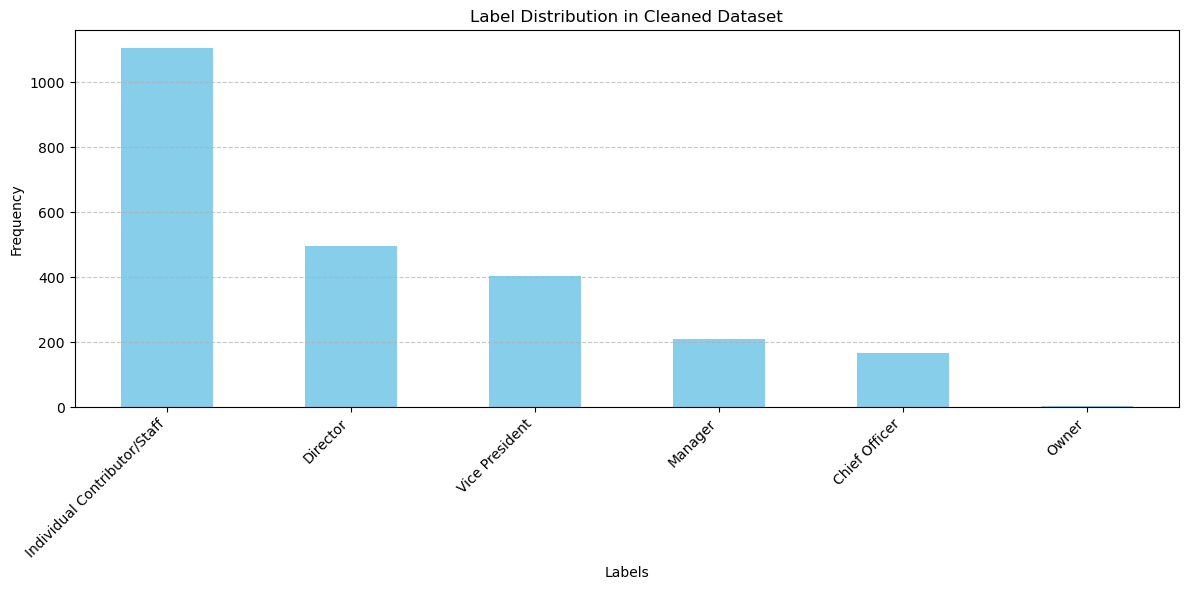

In [70]:
# Checking for balance in dataset

# Identify label columns
label_columns = [col for col in data_final.columns if col not in ['Title']]

# Count the occurrences of each label
label_counts = data_final[label_columns].sum().sort_values(ascending=False)

# Display label counts
print("Label Counts:\n", label_counts)

# Plot the label distribution
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Label Distribution in Cleaned Dataset")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [2]:
# Oversampling sparse label 'Owner'

# Load the dataset
data = pd.read_excel('transformed_dataset.xlsx', sheet_name='Sheet1')

# Separate minority and majority classes
minority_class = data[data['Owner'] == 1]
majority_class = data[data['Owner'] == 0]

# Oversample the minority class
minority_oversampled = resample(
    minority_class, 
    replace=True,            # Sample with replacement
    n_samples=150,           # Desired number of samples
    random_state=42          # For reproducibility
)

# Combine the oversampled minority class with the majority class
oversampled_df = pd.concat([majority_class, minority_oversampled])

# Shuffle the dataset
oversampled_df = oversampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the oversampled dataset
oversampled_df.to_excel('oversampled_dataset.xlsx', index=False)

print("Oversampling complete. The new dataset has been saved.")


Oversampling complete. The new dataset has been saved.


In [3]:
# I have added 150 synthetic rows for Owner label to balance dataset
minority_oversampled

,Title,Vice President,Manager,Individual Contributor/Staff,Director,Chief Officer,Owner
1217,"Co-Owner, Vice President and General Counsel",0,0,0,0,0,1
1924,"Founder, COO",0,0,0,0,1,1
22,CoFounder & CTO,0,0,0,0,1,1
1217,"Co-Owner, Vice President and General Counsel",0,0,0,0,0,1
1217,"Co-Owner, Vice President and General Counsel",0,0,0,0,0,1
...,...,...,...,...,...,...,...
1217,"Co-Owner, Vice President and General Counsel",0,0,0,0,0,1
1217,"Co-Owner, Vice President and General Counsel",0,0,0,0,0,1
1217,"Co-Owner, Vice President and General Counsel",0,0,0,0,0,1
22,CoFounder & CTO,0,0,0,0,1,1


In [6]:
print_full(minority_oversampled)

                                             Title  Vice President  Manager  \
1217  Co-Owner, Vice President and General Counsel               0        0   
1924                                  Founder, COO               0        0   
22                                 CoFounder & CTO               0        0   
1217  Co-Owner, Vice President and General Counsel               0        0   
1217  Co-Owner, Vice President and General Counsel               0        0   
1924                                  Founder, COO               0        0   
22                                 CoFounder & CTO               0        0   
22                                 CoFounder & CTO               0        0   
1217  Co-Owner, Vice President and General Counsel               0        0   
118            Chief Operating Officer, Co-Founder               0        0   
1217  Co-Owner, Vice President and General Counsel               0        0   
1217  Co-Owner, Vice President and General Counsel  

In [ ]:
# Now dataset is ready to be fed into further processing
# as oversampled_dataset.xlsx